In [1]:
from scripts import support, insd, kuroda, nras, metrics, vectorization as v, aggregation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix

In [2]:
#CODES


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "NAICS Codes", skiprows=4)
df = df.iloc[:-6,:-1]
df = df.dropna(axis=0, how = 'all')
df = df.fillna(0)

codes = np.array(df)

In [3]:
#DET 2007


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2007")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2007 = np.array(df)
DET_2007 = np.where(DET_2007=='...', 0, DET_2007)
dt_2007 = v.tovector(DET_2007).astype(float)
# np.shape(DET_2007)

In [4]:
#DET 2012


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2012")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2012 = np.array(df)
DET_2012 = np.where(DET_2012=='...', 0, DET_2012)
dt_2012 = v.tovector(DET_2012).astype(float)


#Зануляем элементы, в которых меняется знак
det_2007 = dt_2007
det_2012 = dt_2012
det_2007[dt_2007 * dt_2012 < 0] = 0
det_2012[dt_2007 * dt_2012 < 0] = 0
DET_2012[DET_2007 * DET_2012 < 0] = 0


#Считаем итоги по строкам и столбцам
rows_sums_2012 = np.sum(DET_2012, axis=1)
columns_sums_2012 = np.sum(DET_2012, axis=0)
totals_2012 = np.concatenate((rows_sums_2012, columns_sums_2012)).astype(float)[np.newaxis].T
# DET_2012

In [5]:
#SUM 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2007")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2007 = np.array(df)
SUM_2007 = np.where(SUM_2007=='...', 0, SUM_2007)

SUM_2007[[72, 71]] = SUM_2007[[71, 72]]
sum_2007 = v.tovector(SUM_2007).astype(float)
# np.shape(SUM_2007)

In [6]:
#SUM 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2012")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2012 = np.array(df)
SUM_2012 = np.where(SUM_2012=='...', 0, SUM_2012)

SUM_2012[[72, 71]] = SUM_2012[[71, 72]]
sum_2012 = v.tovector(SUM_2012).astype(float)
# SUM_2012

In [7]:
#SECT 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2007")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2007 = np.array(df)
SECT_2007 = np.where(SECT_2007=='...', 0, SECT_2007)
sect_2007 = v.tovector(SECT_2007).astype(float)
# SECT_2007

In [8]:
#SECT 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2012")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2012 = np.array(df)
SECT_2012 = np.where(SECT_2012=='...', 0, SECT_2012)
sect_2012 = v.tovector(SECT_2012).astype(float)
# SECT_2012

In [9]:
#parsing aggregation codes


sect_rows, sect_columns, sum_rows, sum_columns = aggregation.parse_agg(codes)

In [10]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SUM (73,71)

left_sum = aggregation.make_keym(405, 73, sum_rows)
right_sum = aggregation.make_keym(405, 71, sum_columns)

g_to_sum = csr_matrix(aggregation.keys_to_g(left_sum, right_sum))

In [11]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SECT (17,15)

left_sect = aggregation.make_keym(405, 17, sect_rows)
right_sect = aggregation.make_keym(405, 15, sect_columns)

g_to_sect = csr_matrix(aggregation.keys_to_g(left_sect, right_sect))

In [12]:
g_sum_w_totals = v.addrows((405,405), g_to_sum, sparsed=True)
g_sum_w_totals = v.addcolumns((405,405), g_sum_w_totals, sparsed=True)

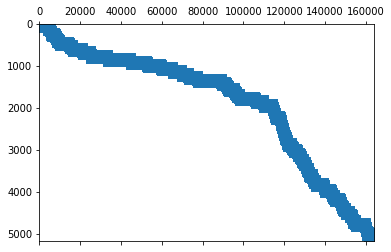

In [13]:
plt.spy(g_to_sum,aspect='auto')

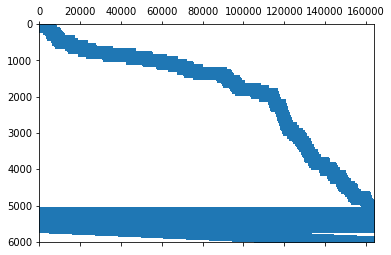

In [14]:
plt.spy(g_sum_w_totals,aspect='auto')

In [15]:
np.shape(totals_2012)

(810, 1)

In [16]:
true_sum_2012 = g_to_sum @ det_2012
sum_2012_with_totals = np.append(sum_2012, totals_2012, axis=0)
true_sum_2012_with_totals = np.append(true_sum_2012, totals_2012, axis=0)

In [17]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Метод: NRAS, точность 0.01, 100 иттераций



result_sum_to_det = np.round(nras.nras(g_to_sum, det_2007, sum_2012, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

1
N0 1483
PSISTAT 0.0338
RSQ 0.9684
MAPE 14.9574
SWAD 0.066
WAPE 23.2183


In [18]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: NRAS, точность 0.01, 100 иттераций


result_sum_to_det = np.round(nras.nras(g_to_sum, det_2007, true_sum_2012, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

1
N0 1481
PSISTAT 0.0338
RSQ 0.9684
MAPE 14.9614
SWAD 0.066
WAPE 23.2184


In [19]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: NRAS, точность 0.01, 100 иттераций




result_sum_to_det = np.round(nras.nras(g_sum_w_totals, det_2007, sum_2012_with_totals, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

100
N0 1461
PSISTAT 0.0146
RSQ 0.9909
MAPE 9.9558
SWAD 0.0317
WAPE 13.0282


In [20]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012 + итоги по строкам и столбцам
#Метод: NRAS, точность 0.01, 100 иттераций




result_sum_to_det = np.round(nras.nras(g_sum_w_totals, det_2007, true_sum_2012_with_totals, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

100
N0 1451
PSISTAT 0.0146
RSQ 0.9909
MAPE 9.9497
SWAD 0.0317
WAPE 13.0281


In [21]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_to_sum, det_2007, sum_2012, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [22]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_to_sum, det_2007, true_sum_2012, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [23]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_sum_w_totals, det_2007, sum_2012_with_totals, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [24]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012 + итоги по строкам и столбцам
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_sum_w_totals, det_2007, true_sum_2012_with_totals, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [25]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_to_sum, det_2007, sum_2012, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [26]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_to_sum, det_2007, true_sum_2012, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [27]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_sum_w_totals, det_2007, sum_2012_with_totals, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [28]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012 + итоги по строкам и столбцам
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_sum_w_totals, det_2007, true_sum_2012_with_totals, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [29]:
ttls = v.addrows((405,405))
ttls = v.addcolumns((405,405), ttls)

tst = kuroda.kuroda(ttls, det_2007, totals_2012, 1)
metrics.get_values(tst, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
N0 1514
PSISTAT 0.0427
RSQ 0.95
MAPE 13.6231
SWAD 0.1043
WAPE 26.693


In [30]:
tst = insd.insd(ttls, det_2007, totals_2012)
metrics.get_values(tst, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 67, in insd
    model.optimize()
  File "model.pxi", line 727, in gurobipy.Model.optimize
gurobipy.GurobiError: Objective Q not PSD (negative diagonal entry)

ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\vectorization.py", line 124, in tovector
    return a.T.flatten()[np.newaxis].T
AttributeError: 'int' object has no attribute 'T'

ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\metrics.py", line 180, in PsiStat
    if x.ndim == 1 or x.shape[1] == 1:
AttributeError: 'int' object has no attribute 'ndim'

ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\metrics.py", line 224, in RSQ
    if x.ndim == 1 or x.shape[1] == 1:
AttributeError: 'int' object has no attribute 'ndim'

ERROR:root:Traceback (most recent

N0 44906
PSISTAT -1
RSQ -1
MAPE -1
SWAD -1
WAPE -1
